## <center> Import and Glimpse of Data

### <center> Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28, 18

%matplotlib inline
plt.style.use('ggplot')
import dask.dataframe as dd
import gc

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)    #THIS LINE IS MOST IMPORTANT AS THIS WILL DISPLAY PLOT ON 
#NOTEBOOK WHILE KERNEL IS RUNNING
import plotly.graph_objs as go              
import plotly.express as px                 
import plotly.offline as py     # 绘图的函数

### <center> Read Data

In [2]:
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
train_df = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test_df = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

### <center> Data Merge

In [3]:
train_df = train_df.merge(building, on='building_id', how='left')
test_df = test_df.merge(building, on='building_id', how='left')

train_df = train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test_df = test_df.merge(weather_test, on=['site_id', 'timestamp'], how='left')

train_df['timestamp'] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
test_df['timestamp'] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S')


del weather_train, weather_test,building
gc.collect();

### <center>Reduce Memory

In [4]:
def reduce_mem_usage(df, verbose=True):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # 计算当前占用的内存 
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    # 循环每一列
    for col in df.columns:

        # 获取每一列的数据类型
        col_type = df[col].dtypes

        # 如果数据类型属于上面定义的类型之
        if col_type in numerics:

            # 计算该列数据的最小值和最大值 用于我们指定相应的数据类型 
            c_min = df[col].min()
            c_max = df[col].max()

            # 如果 该列的数据类型属于 int 类型，然后进行判断
            if str(col_type)[:3] == 'int':
                # 如果 该列最小的值 大于int8类型的最小值，并且最大值小于int8类型的最大值，则采用int8类型 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)

                # 同上
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)

                # 同上
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)

                # 同上
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # 否则 则采用 float 的处理方法       
            else:

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2

    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train_df['hour'] = train_df.timestamp.dt.hour
train_df['day'] = train_df.timestamp.dt.day
train_df['week'] = ((train_df.timestamp.dt.dayofweek) // 5 == 1).astype(float) 
train_df['month'] = train_df.timestamp.dt.month

test_df['hour'] = test_df.timestamp.dt.hour
test_df['day'] = test_df.timestamp.dt.day
test_df['week'] = ((test_df.timestamp.dt.dayofweek) // 5 == 1).astype(float) 
test_df['month'] = test_df.timestamp.dt.month

In [6]:
train_bd = np.round(train_df.memory_usage().sum()/(1024*1024),1)
test_bd = np.round(test_df.memory_usage().sum()/(1024*1024),1)

In [7]:
%%time

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 2705.42 Mb (38.8% reduction)
Mem. usage decreased to 5581.83 Mb (38.8% reduction)
CPU times: user 19.4 s, sys: 3.56 s, total: 22.9 s
Wall time: 22.9 s


In [8]:
train_ad = np.round(train_df.memory_usage().sum()/(1024*1024),1)
test_ad = np.round(test_df.memory_usage().sum()/(1024*1024),1)

### <center> Plot Memory Reduce 

In [9]:
memory = pd.DataFrame({
    'DataFrame':['train','test'],
    'Before memory reducing':[train_bd,test_bd],
    'After memory reducing':[train_ad,test_ad],

})

memory = pd.melt(memory,id_vars='DataFrame',var_name='Status',value_name='Memory(MB)')
memory.sort_values('Memory(MB)',inplace=True)
fig = px.bar(memory,x='DataFrame',y='Memory(MB)',color='Status',barmode='group',text='Memory(MB)')
fig.update_traces(textposition='outside')
fig.update_layout(template='seaborn',title='Effect of Downcasting')
fig.show()

In [10]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,week,month
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,0.0,1
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,0.0,1
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,0.0,1
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,0.0,1
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,0.0,1


### <center> Data info

In [11]:
%%time

stats = []
for col in train_df.columns:
    stats.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))

# 列分别为 特征名、该特征独立值数量、该特征缺失值比例、该特征下出现最多的值占所有值的比例、数据类型
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

CPU times: user 12.1 s, sys: 1.39 s, total: 13.5 s
Wall time: 13.5 s


,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
8,floor_count,18,82.652772,82.652772,float32
7,year_built,116,59.990033,59.990033,float32
10,cloud_coverage,10,43.655131,43.655131,float32
12,precip_depth_1_hr,128,18.544739,71.811937,float32
14,wind_direction,43,7.167792,11.740840,float32
13,sea_level_pressure,709,6.092515,6.092515,float32
15,wind_speed,58,0.710701,11.796345,float32
11,dew_temperature,522,0.495348,1.978730,float32
9,air_temperature,619,0.478124,1.958662,float32
18,week,2,0.000000,71.349400,float32


In [12]:
%%time

stats = []
for col in test_df.columns:
    stats.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))

# 列分别为 特征名、该特征独立值数量、该特征缺失值比例、该特征下出现最多的值占所有值的比例、数据类型
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

CPU times: user 28 s, sys: 5.22 s, total: 33.2 s
Wall time: 33.2 s


,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
8,floor_count,18,82.605042,82.605042,float32
7,year_built,116,58.991597,58.991597,float32
10,cloud_coverage,10,46.866438,46.866438,float32
12,precip_depth_1_hr,174,18.709861,70.409256,float32
14,wind_direction,60,7.143488,11.503084,float32
13,sea_level_pressure,717,6.035901,6.035901,float32
15,wind_speed,78,0.724476,11.565407,float32
11,dew_temperature,559,0.625453,2.024579,float32
9,air_temperature,639,0.532167,2.030975,float32
18,week,2,0.000000,71.369863,float32


`floor_count` have a lot of missing values for count ，that seem to say nothing

In [13]:
train_df.drop(columns='floor_count',inplace=True)
test_df.drop(columns='floor_count',inplace=True)

## <center> Visualization and Data Processing

In [14]:
category_features=['hour','day','week','month','primary_use','meter','site_id'] 
train_df[category_features] = train_df[category_features].astype('category')
test_df[category_features] = test_df[category_features].astype('category')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 19 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               category      
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             category      
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float32       
 8   air_temperature     float32       
 9   cloud_coverage      float32       
 10  dew_temperature     float32       
 11  precip_depth_1_hr   float32       
 12  sea_level_pressure  float32       
 13  wind_direction      float32       
 14  wind_speed          float32       
 15  hour                category      
 16  day                 category      
 17  week                category      
 18  month               category      
dtypes: category(7), datetime64[ns](1), float

In [15]:
# train_df.info()

In [16]:
%%time

stats = []
for col in train_df.columns:
    stats.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))

# 列分别为 特征名、该特征独立值数量、该特征缺失值比例、该特征下出现最多的值占所有值的比例、数据类型
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

CPU times: user 7.61 s, sys: 1.23 s, total: 8.84 s
Wall time: 8.84 s


,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
7,year_built,116,59.990033,59.990033,float32
9,cloud_coverage,10,43.655131,43.655131,float32
11,precip_depth_1_hr,128,18.544739,71.811937,float32
13,wind_direction,43,7.167792,11.740840,float32
12,sea_level_pressure,709,6.092515,6.092515,float32
14,wind_speed,58,0.710701,11.796345,float32
10,dew_temperature,522,0.495348,1.978730,float32
8,air_temperature,619,0.478124,1.958662,float32
17,week,2,0.000000,71.349400,category
16,day,31,0.000000,3.304673,category


In [17]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,week,month
0,0,0,0,2017-01-01,0,Education,7432,2008.0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,0,1,1.0,1
1,1,1,0,2017-01-01,0,Education,2720,2004.0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,0,1,1.0,1
2,2,2,0,2017-01-01,0,Education,5376,1991.0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,0,1,1.0,1
3,3,3,0,2017-01-01,0,Education,23685,2002.0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,0,1,1.0,1
4,4,4,0,2017-01-01,0,Education,116607,1975.0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,0,1,1.0,1


### 筛选出 train 和 test 共同列

In [18]:
print('B Training Features shape: ', train_df.shape)
print('B Testing Features shape: ', test_df.shape)

train_labels = train_df['meter_reading']

# Align the training and testing data, keep only columns present in both dataframes 
# 选出两个数据中共同拥有的列，不共有的列过滤出去
train_df, test_df = train_df.align(test_df, join = 'inner', axis = 1)

# Add the target back in
train_df['meter_reading'] = train_labels

print('A Training Features shape: ', train_df.shape)
print('A Testing Features shape: ', test_df.shape)

B Training Features shape:  (20216100, 19)
B Testing Features shape:  (41697600, 19)
A Training Features shape:  (20216100, 19)
A Testing Features shape:  (41697600, 18)


### look at train and test dist

In [19]:
# Density plots of features function
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))
    
    failed_features = []
    
    for feature in features:
        try:
            i += 1
            plt.subplot(5,2,i)
            sns.distplot(df1[feature], hist=False,label=label1)
            sns.distplot(df2[feature], hist=False,label=label2)
            plt.xlabel(feature, fontsize=9)
            locs, labels = plt.xticks()
            plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=6)
        except:
            print(feature + 'KDE failed')
            failed_features.append(feature)
            continue
    plt.show();
    
    return failed_features

In [20]:
sns.set_style('darkgrid')

### year_built:

In [21]:
# plotly func 

# def plot_categorical_feature(col,top_n=10000,train=train_df):
    
#     top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
#     print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
#     print(train[col].value_counts(normalize=True, dropna=False).head())
    
#     top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
    
#     df = train.groupby([col]).agg({'meter_reading': ['count','mean']})
#     df = df.sort_values(('meter_reading', 'count'), ascending=False).head(top_n).sort_index()
    
#     data = [go.Bar(x=df.index, y=df['meter_reading']['count'], name='counts'),
#             go.Bar(x=df.index, y=df['meter_reading']['count'], name='counts'),
#             go.Scatter(x=df.index, y=df['meter_reading']['mean'], name='meter_reading mean', yaxis='y2')]

    
    
#     layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
#                             xaxis = dict(title = f'{col}',
#                                     showgrid=False,
#                                     zeroline=False,
#                                     showline=False,),
#                             yaxis = dict(title = 'Counts',
#                                     showgrid=False,
#                                     zeroline=False,
#                                     showline=False,),
#                             yaxis2=dict(title='meter_reading mean', 
#                                         overlaying='y', 
#                                         side='right')
#                             ),
#                     legend=dict(orientation="v"), barmode='group')

#     py.iplot(dict(data=data, layout=layout))

In [22]:
[col for col in train_df.columns if col != 'meter_reading' and col not in category_features and col != 'timestamp']

['building_id',
 'square_feet',
 'year_built',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

precip_depth_1_hrKDE failed


<Figure size 432x288 with 0 Axes>

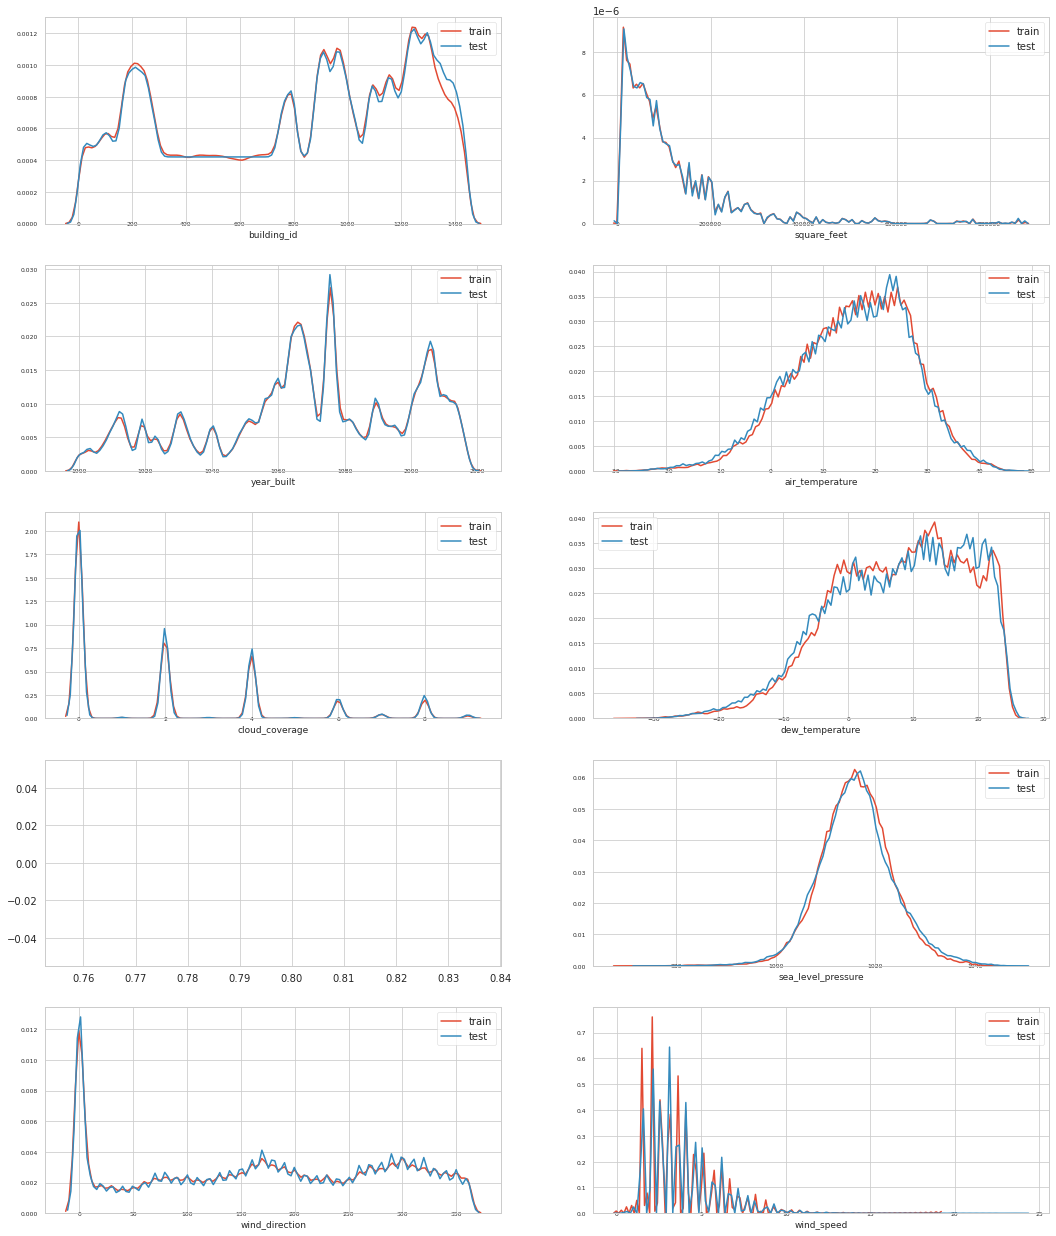

['precip_depth_1_hr']

In [23]:
features = [col for col in train_df.columns if col != 'meter_reading' and col not in category_features and col != 'timestamp']
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

we can see that the distribution of training data and test data is basically the same

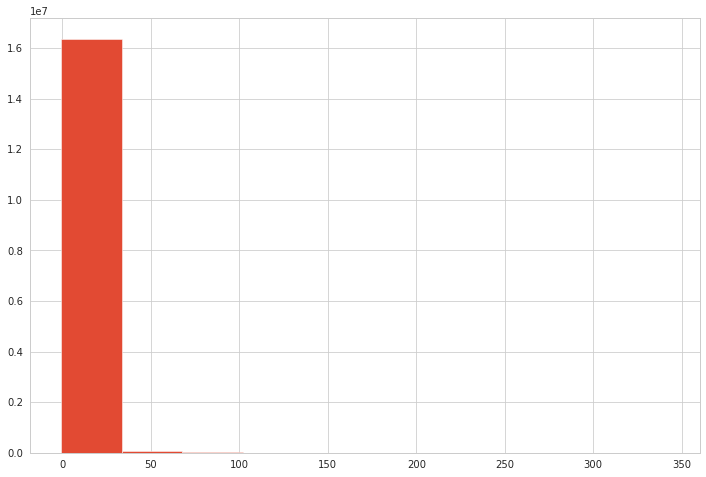

In [24]:
train_df['precip_depth_1_hr'].hist(figsize=(12,8))

### meter_reading

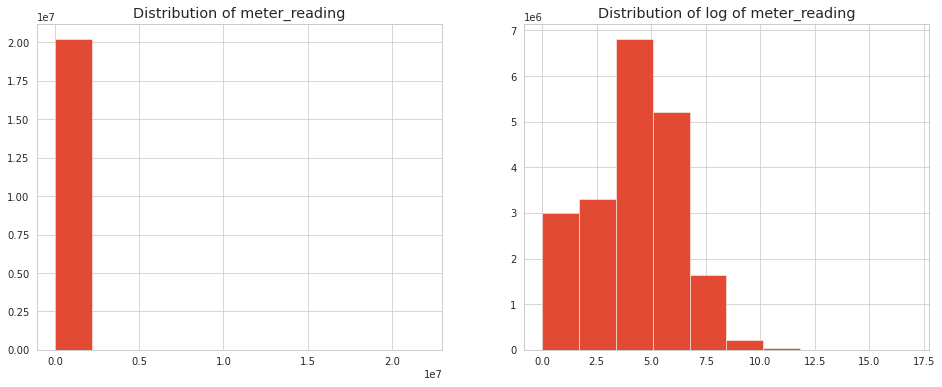

In [25]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['meter_reading']);
plt.title('Distribution of meter_reading');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['meter_reading']));
plt.title('Distribution of log of meter_reading');

### meter:

In [26]:
# plot_categorical_feature('meter')

### <center>Classified data：

In [27]:
def Classification_features_and_continuous_targets_func(col,target='meter_reading',rotation=0,loc=2):
    
    # 训练数据
    train_data = train_df[col].value_counts(dropna=False, normalize=True).sort_index().values
    ind = np.arange(len(train_data))
    width = 0.35

    fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
    tr = axes.bar(ind, train_data, width, color='royalblue')
    
    # 测试数据
    test_data = test_df[col].value_counts(dropna=False, normalize=True).sort_index().values
    tt = axes.bar(ind+width, test_data, width, color='seagreen')

    axes.set_ylabel('Normalized number of observations');
    axes.set_xlabel(col);
    axes.set_xticks(ind + width / 2)
    axes.set_xticklabels(train_df[col].value_counts().sort_index().index, rotation=rotation)
    axes2 = axes.twinx()
    mr = axes2.plot(ind, train_df[[col, target]].groupby(col)[target].mean().sort_index().values, 'D-', color='tab:orange', label='Mean {}'.format(target));
    axes2.grid(False);
    axes2.tick_params(axis='y', labelcolor='tab:orange');
    axes2.set_ylabel('Mean {} by {}'.format(target,col), color='tab:orange');
    axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
    axes2.legend(loc=loc, facecolor='white');

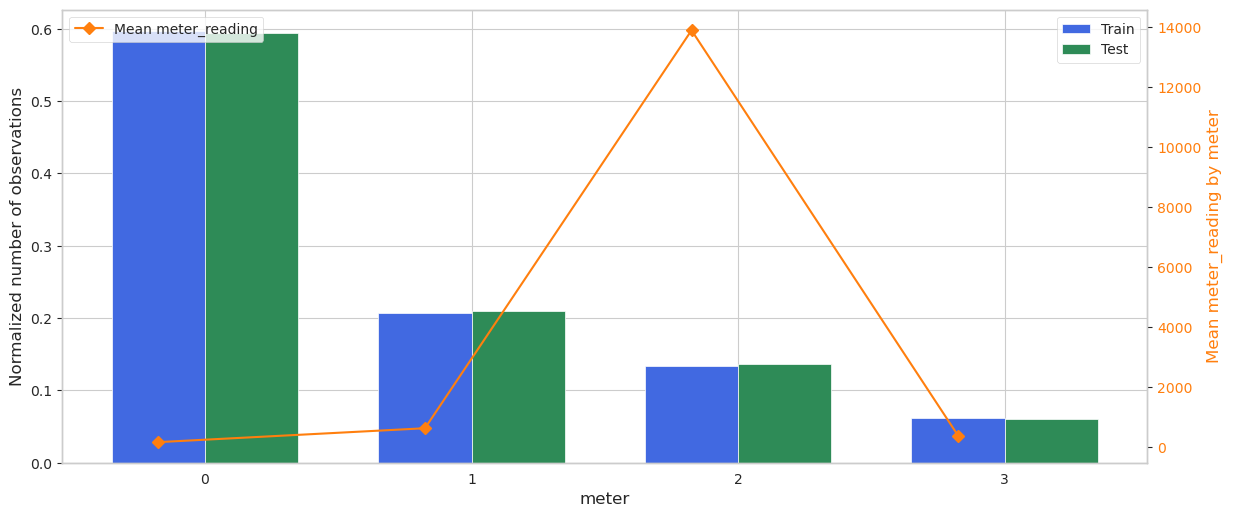

In [28]:
Classification_features_and_continuous_targets_func('meter','meter_reading')

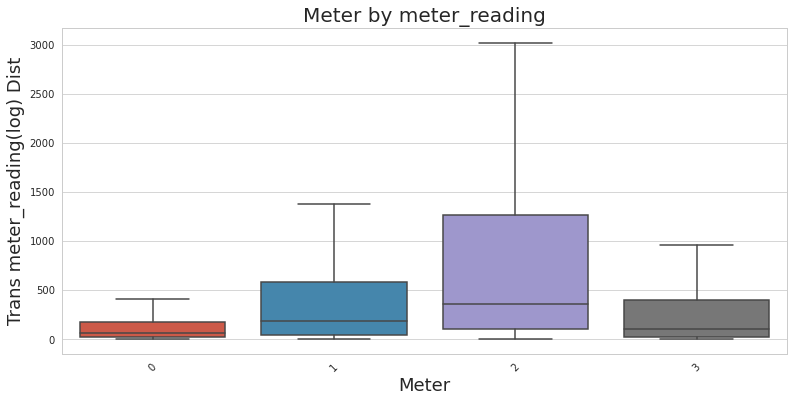

In [29]:
plt.figure(figsize=(13,6)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxplot(x='meter', y='meter_reading', 
                   data=train_df[(train_df['meter'].isin((train_df['meter'].value_counts()[:10].index.values))) &
                                  train_df['meter_reading'] > 0]
                   ,showfliers=False)
g1.set_title('Meter by meter_reading', fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Meter', fontsize=18) # Xlabel
g1.set_ylabel('Trans meter_reading(log) Dist', fontsize=18) #Ylabel

plt.show()

### site_id:

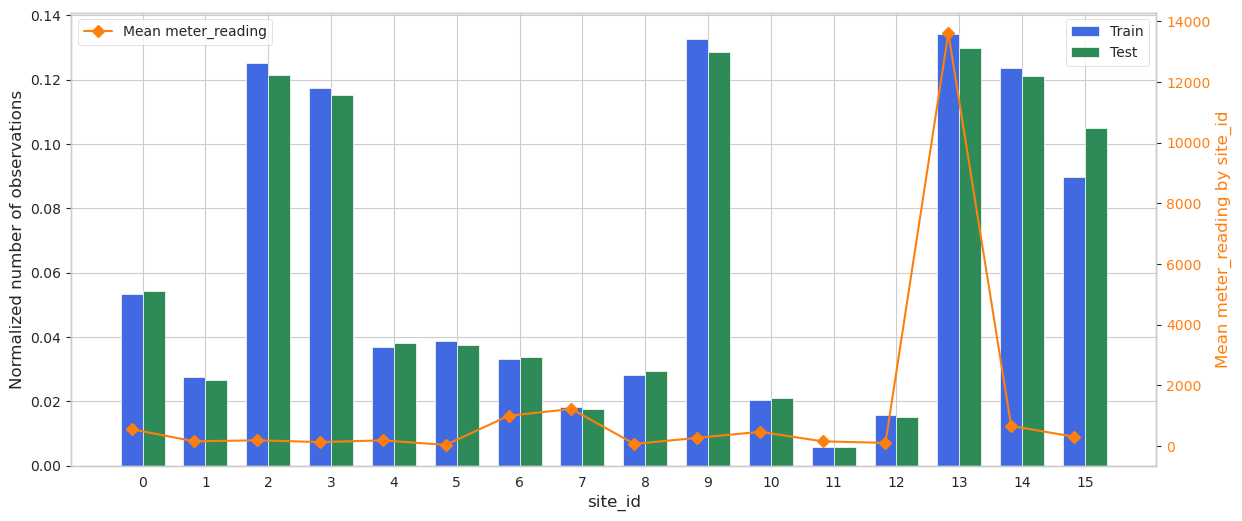

In [30]:
Classification_features_and_continuous_targets_func('site_id',rotation=0)

### cloud_coverage:

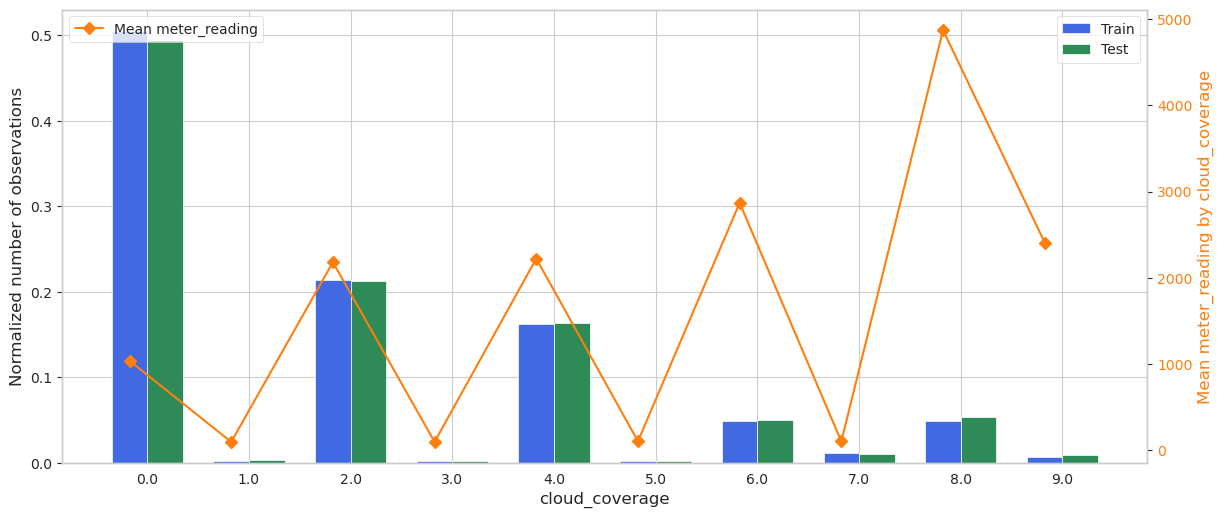

In [31]:
train_data = train_df['cloud_coverage'].value_counts(normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

# 测试数据
test_data = test_df['cloud_coverage'].value_counts(normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('cloud_coverage');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['cloud_coverage'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['cloud_coverage', 'meter_reading']].groupby('cloud_coverage')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean {}'.format('meter_reading'));
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean {} by {}'.format('meter_reading','cloud_coverage'), color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### primary_use:

In [32]:
# plot_categorical_feature('primary_use')

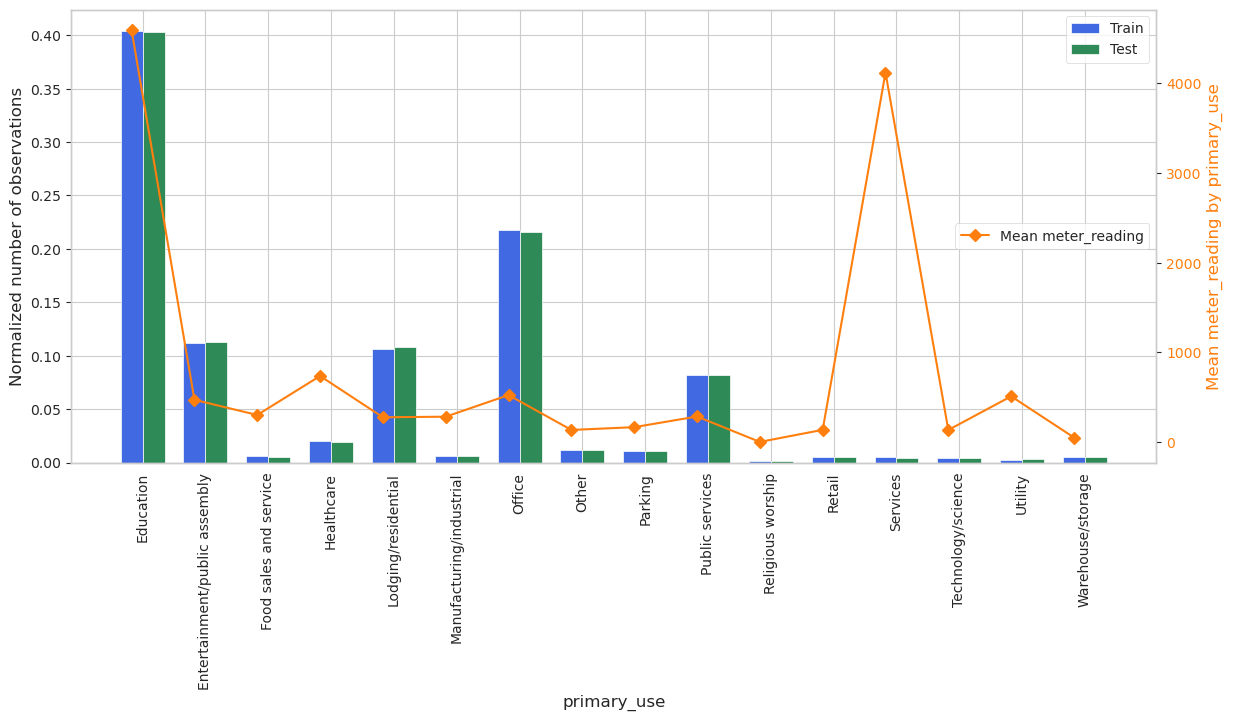

In [33]:
Classification_features_and_continuous_targets_func('primary_use',rotation=90,loc=5)

education and services meter_reading is very big

### timestamp:

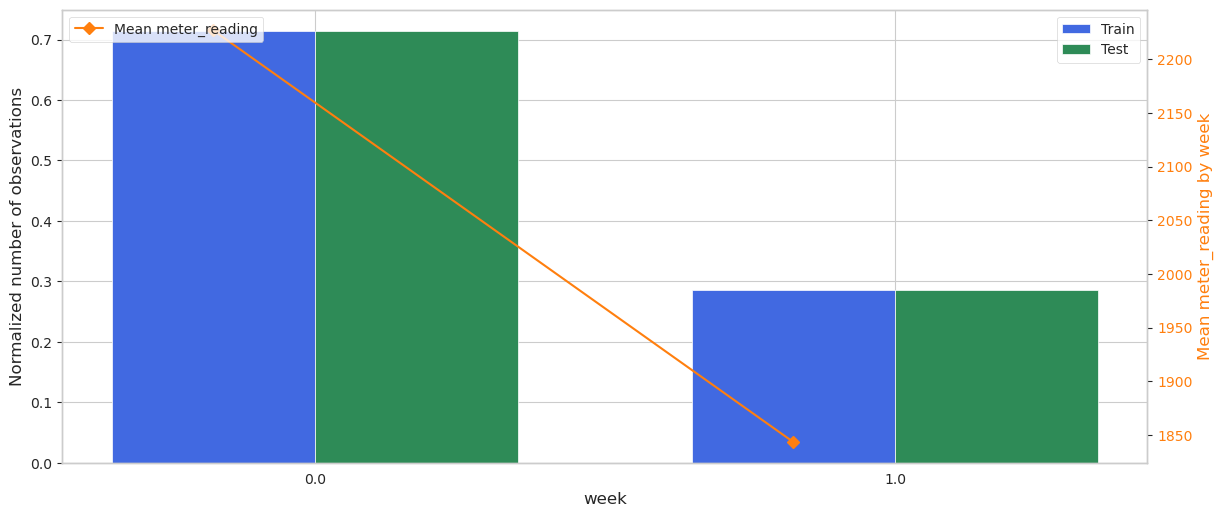

In [34]:
Classification_features_and_continuous_targets_func('week',rotation=0)

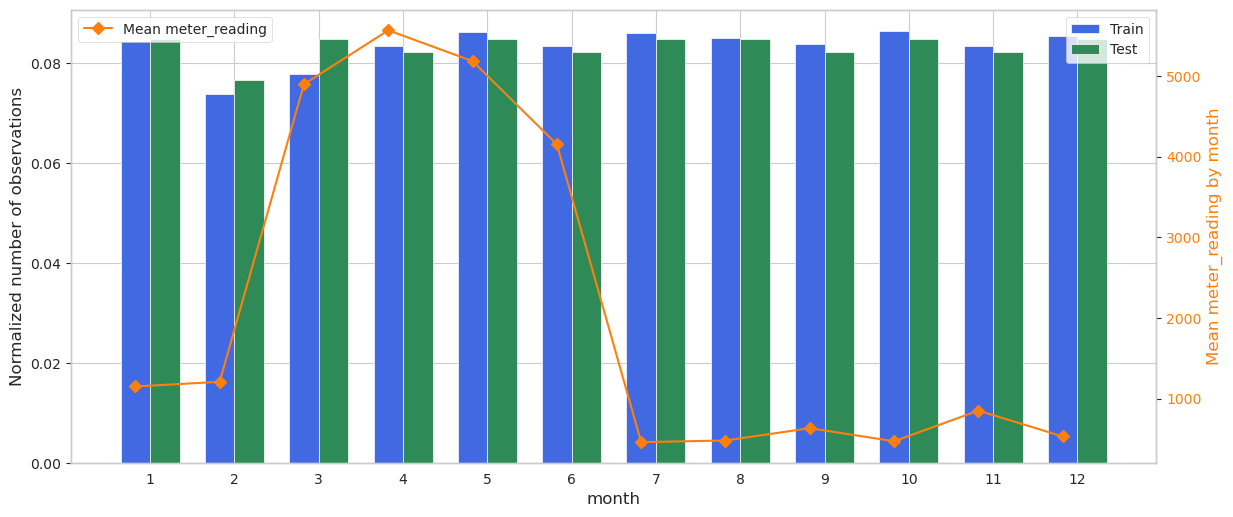

In [35]:
Classification_features_and_continuous_targets_func('month',rotation=0)

In [36]:
# plot_categorical_feature('hour')

In [37]:
# plot_categorical_feature('day')

In [38]:
# plot_categorical_feature('week')

In [39]:
# plot_categorical_feature('month')

### <center>Continuous data：

### timestamp：

In [40]:
# Calling the function to transform the date column in datetime pandas object

# 设置一些静态颜色选项
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
        '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
        '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

dates_temp = train_df.groupby(train_df.timestamp.dt.date)['meter_reading'].mean().reset_index()

# 使用第一个必要的 trace 参数，opacity 表示透明度
trace = go.Scatter(x=dates_temp['timestamp'], y=dates_temp.meter_reading,
                opacity = 0.8, line = dict(color = color_op[7]), name= 'Meter_reading mean')

# 下面我们将得到销售总额 (具体案例具体分析)
dates_temp_sum = train_df.groupby(train_df.timestamp.dt.date)['meter_reading'].sum().reset_index()

# 使用新的 dates_temp_sum ，我们将创建第二个 trace 
trace1 = go.Scatter(x=dates_temp_sum.timestamp, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['meter_reading'], opacity = 0.8, yaxis='y2')

# 创建布局将允许我们给出标题和给我们一些有趣的选项来处理图的输出
layout = dict(
        title= "Total meter_reading Informations by Date",
        xaxis=dict(
                rangeselector=dict(
                buttons=list([
                        dict(count=1, label='1m', step='month', stepmode='backward'),
                        dict(count=3, label='3m', step='month', stepmode='backward'),
                        dict(count=6, label='6m', step='month', stepmode='backward'),
                        dict(step='all')
                ])
                ),
                rangeslider=dict(visible = True), # 控制最下面的图
                type='date' ),
        yaxis=dict(title='Total meter_reading'), # 左侧的y轴
        yaxis2=dict(overlaying='y',             # 右侧的y轴 side ='right'
                        anchor='x', side='right',
                        zeroline=False, showgrid=False,
                        title='Total meter_reading Amount')
        )

# 创建既有 trace 又有 layout 的图形
fig = dict(data= [trace, trace1,], layout=layout)

#绘制图形
iplot(fig) #it's an equivalent to plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



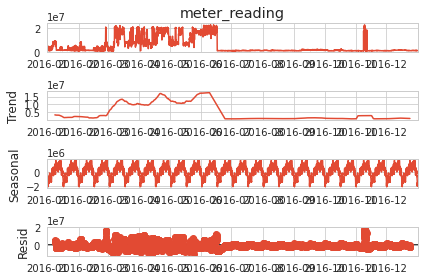

In [41]:
meter_reading_sum = train_df[['timestamp','meter_reading']].groupby(['timestamp']).sum()
meter_reading_sum.head()


from statsmodels.tsa.seasonal import seasonal_decompose

weeks_per_year = 365


time_series = meter_reading_sum['meter_reading']
sj_sc = seasonal_decompose(time_series, freq= weeks_per_year)
sj_sc.plot()

plt.show()

In [42]:
# fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
# for i in range(train_df['site_id'].nunique()):
#     train_df[train_df['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=13);
#     test_df[test_df['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
#     train_df[train_df['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
#     test_df[test_df['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
#     axes[i%8][i//8].legend();
#     axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
#     axes[i%8][i//8].axvspan(test_df['timestamp'].min(), test_df['timestamp'].max(), facecolor='green', alpha=0.2);
#     plt.subplots_adjust(hspace=0.45)

### precip_depth_1_hr

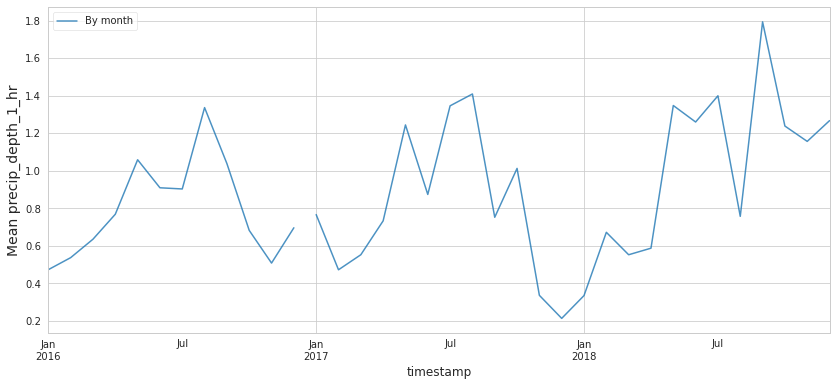

In [43]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, label='By month', color='tab:blue').set_ylabel('Mean precip_depth_1_hr', fontsize=14);
test_df[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
axes.legend();

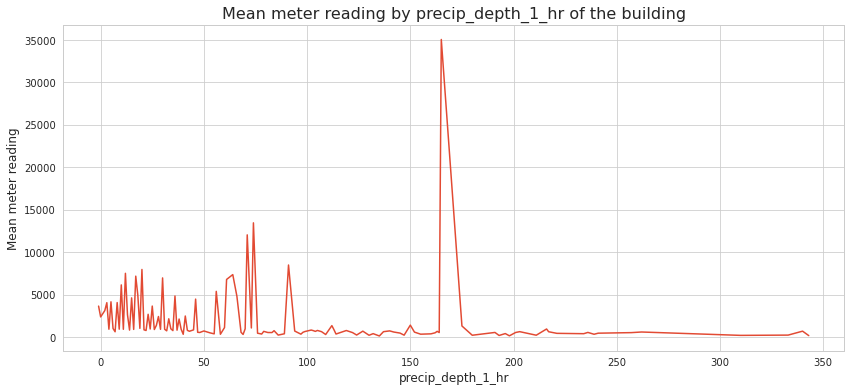

In [44]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('precip_depth_1_hr')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by precip_depth_1_hr of the building', fontsize=16);

### year_built：

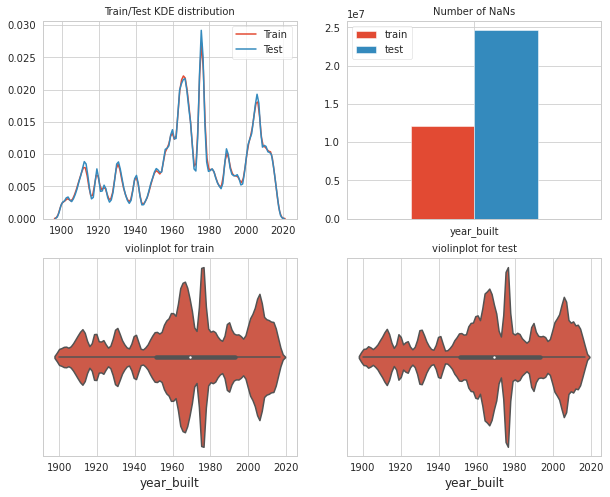

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.kdeplot(train_df['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test_df['year_built'], ax=axes[0][0], label='Test');
sns.violinplot(x=train_df['year_built'], ax=axes[1][0]);
sns.violinplot(x=test_df['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train_df['year_built'].isnull().sum()], 'test': [test_df['year_built'].isnull().sum()]},index=['year_built']).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution',fontsize=10);
axes[0][1].set_title('Number of NaNs',fontsize=10);
axes[1][0].set_title('violinplot for train',fontsize=10);
axes[1][1].set_title('violinplot for test',fontsize=10);
gc.collect();

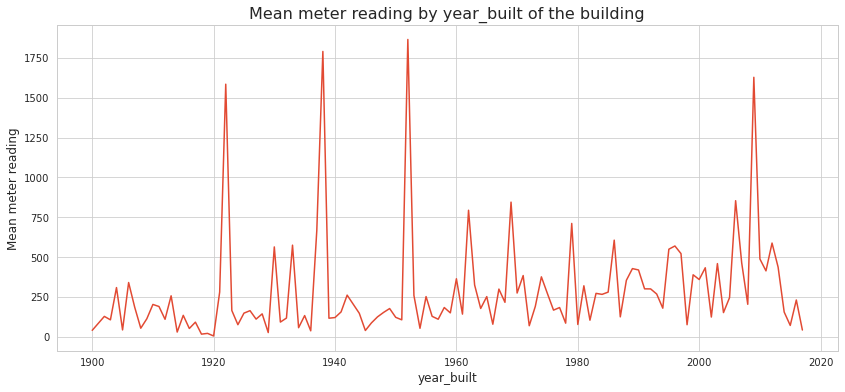

In [46]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

### building_id

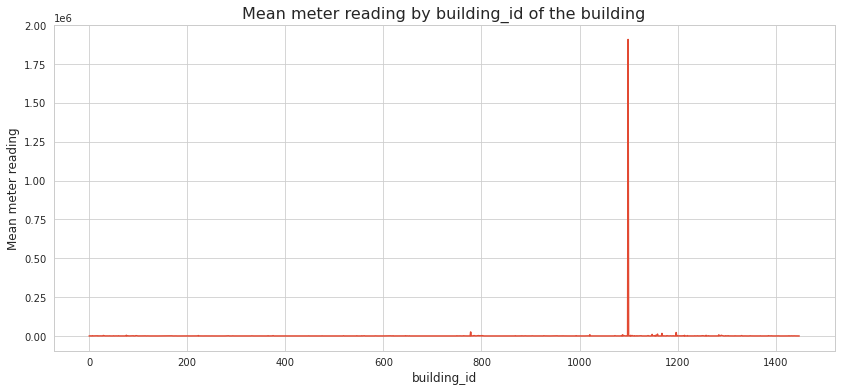

In [47]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('building_id')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by building_id of the building', fontsize=16);

As shown in the figure ： may be have outliers in the data，Let's explore further

In [48]:
train_df[(train_df['meter_reading'] > 2500000)]['building_id'].unique()

array([1099], dtype=int16)

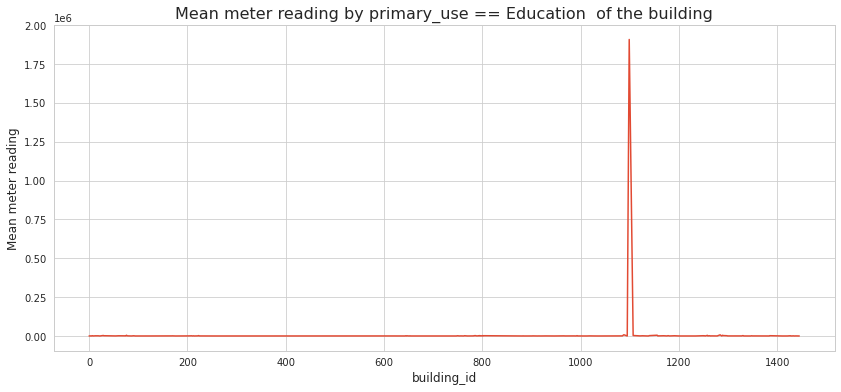

In [49]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df[(train_df['primary_use'] == 'Education')].groupby('building_id')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by primary_use == Education  of the building', fontsize=16);

There is an obvious outlier in data. building id == 1099

能看到在 primary_use == Education 的数据中，building_id = 1099 的数据好像存在异常

Mean meter reading by building_id WITHOUT building_id 1099 

这里排除  building_id 1099 的数据再来看一下：

Text(0, 0.5, 'Mean meter reading')

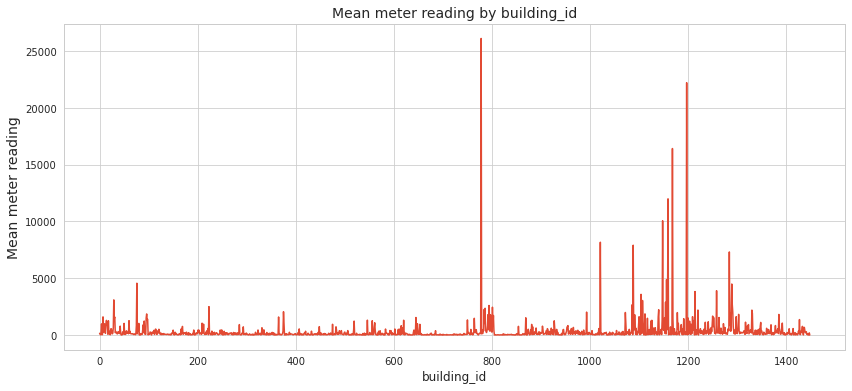

In [50]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df[train_df['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14)

### square_feet:

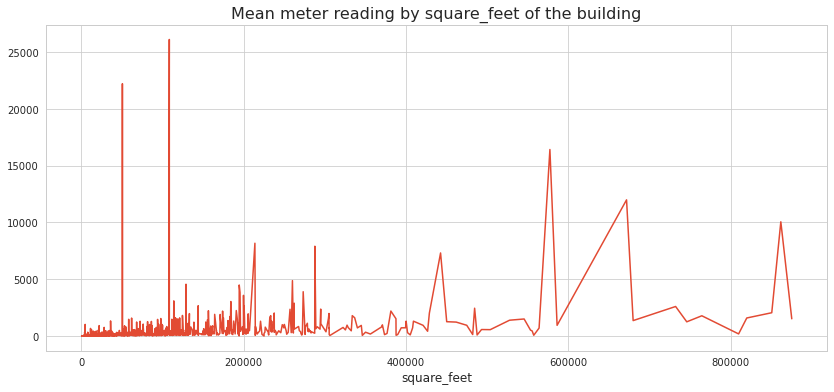

In [51]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df[train_df['building_id'] != 1099].groupby('square_feet')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by square_feet of the building', fontsize=16);

在图中我们似乎比较难直接发现 square_feet 和 meter_reading之间的关系

### wind_speed:

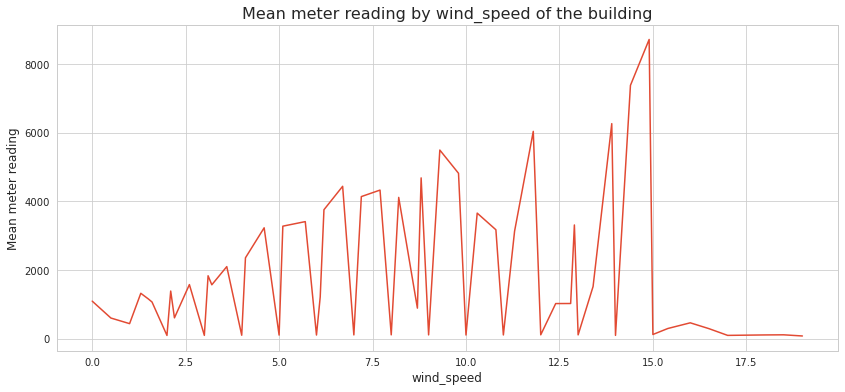

In [52]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('wind_speed')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by wind_speed of the building', fontsize=16);

### air_temperature:

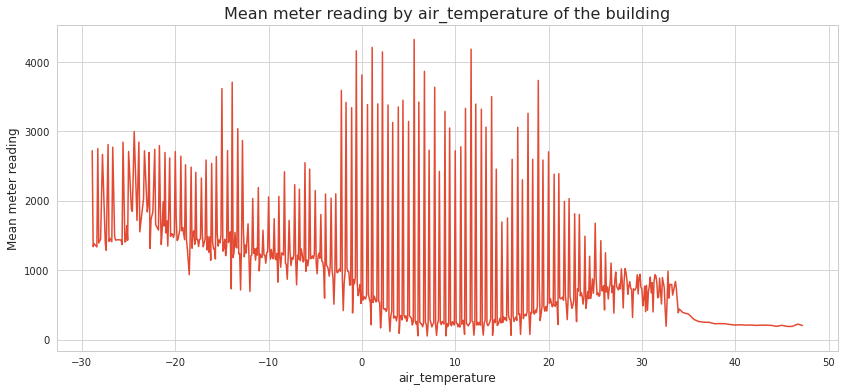

In [53]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('air_temperature')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by air_temperature of the building', fontsize=16);